<h1>ASSIGNMENT1</h1><h2>Download modules</h2>

In [0]:
!pip install SimpleITK
!pip install PyDrive
!pip install h5py
!pip install git+git://github.com/Hvass-Labs/scikit-optimize.git@dd7433da068b5a2509ef4ea4e5195458393e6555


  Cloning git://github.com/Hvass-Labs/scikit-optimize.git (to revision dd7433da068b5a2509ef4ea4e5195458393e6555) to /tmp/pip-req-build-q3sn9ntj
  Stored in directory: /tmp/pip-ephem-wheel-cache-2hjtp7au/wheels/e2/8b/7e/2956a87f1fb737a8c3f2ed18788b5e0ecfe4718141988c838f
Successfully built scikit-optimize


<h2>Import modules</h2>

In [0]:
import os
import requests
import shutil
import subprocess
import zipfile
from functools import partial

import tensorflow as tf
import tensorflow.keras
import h5py
import random
from tensorflow.keras.layers import Input, LeakyReLU, Add, SpatialDropout2D,Conv2D, MaxPooling2D, UpSampling2D, Activation, BatchNormalization, PReLU,concatenate,Layer, InputSpec
from tensorflow.keras import Model,initializers, regularizers, constraints,Sequential
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD
from tensorflow.keras import backend as K

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import multiprocessing as mp

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

<h2> Unzip in google drive</h2>(NOT IMPORTANT)

In [0]:
# drive.mount("/content/drive")
# with zipfile.ZipFile("/content/drive/My Drive/BRATS2015_Training.zip","r") as zip_ref:
#     zip_ref.extractall("/content/drive/My Drive/")

<h2>Local Unzip</h2>

In [0]:
## connect to drive and Locally download the file

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': '1AFiE99KilM3w9-f3BzhFSN_3_ztF5KTK'})
download.GetContentFile('BRATS2015.tar')

In [0]:
## Locally extract the zip

with zipfile.ZipFile("./BRATS2015.tar","r") as zip_ref:
    zip_ref.extractall("./BRATS2015")

<h2>Tunneling to TENSORBOARD</h2>

In [0]:
__all__ = [
  'install_ngrok', 
  'launch_tensorboard',
]

def __shell__(cmd, split=True):
  # get_ipython().system_raw(cmd)
  result = get_ipython().getoutput(cmd, split=split)
  if result and not split:
    result = result.strip('\n')
  return result  


# tested OK
def install_ngrok(bin_dir="/tmp"):
  """ download and install ngrok on local vm instance
  Args:
    bin_dir: full path for the target directory for the `ngrok` binary
  """
  TARGET_DIR = bin_dir
  CWD = os.getcwd()
  is_grok_avail = os.path.isfile(os.path.join(TARGET_DIR,'ngrok'))
  if is_grok_avail:
    print("ngrok installed")
  else:
    import platform
    plat = platform.platform() # 'Linux-4.4.64+-x86_64-with-Ubuntu-17.10-artful'
    if 'x86_64' in plat:
      
      os.chdir('/tmp')
      print("calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ..." )
      get_ipython().system_raw( "wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip" )
      print("calling unzip ngrok-stable-linux-amd64.zip ...")
      get_ipython().system_raw( "unzip ngrok-stable-linux-amd64.zip" )
      os.rename("ngrok", "{}/ngrok".format(TARGET_DIR))
      os.remove("ngrok-stable-linux-amd64.zip")
      is_grok_avail = os.path.isfile(os.path.join(TARGET_DIR,'ngrok'))
      os.chdir(TARGET_DIR)
      if is_grok_avail:
        print("ngrok installed. path={}".format(os.path.join(TARGET_DIR,'ngrok')))
      else:
        # ValueError: ERROR: ngrok not found, path=
        raise ValueError( "ERROR: ngrok not found, path=".format(TARGET_DIR) )
    else:
      raise NotImplementedError( "ERROR, ngrok install not configured for this platform, platform={}".format(plat))
    os.chdir(CWD)
    return
    
# tested OK
def launch_tensorboard(bin_dir="/tmp", log_dir="/tmp", retval=False):
  """returns a public tensorboard url based on the ngrok package
  checks if `ngrok` is available, and installs, if necessary, to `bin_dir`
  launches tensorboard, if necessary
  see: https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab
  Args:
    bin_dir: full path for the target directory for the `ngrok` binary
    log_dir: full path for the tensorflow `log_dir`
  Return:
    public url for tensorboard if retval==True
      NOTE: the method will print a link to stdout (cell output) for the tensorflow URL. 
      But the link printed from the return value has an extra "%27" in the URL which causes an error
  """
  install_ngrok(bin_dir)
    
  if not tf.gfile.Exists(log_dir):  tf.gfile.MakeDirs(log_dir)
  
  # check status of tensorboard and ngrok
  ps = __shell__("ps -ax")
  is_tensorboard_running = len([f for f in ps if "tensorboard" in f ]) > 0
  is_ngrok_running = len([f for f in ps if "ngrok" in f ]) > 0
  print("status: tensorboard={}, ngrok={}".format(is_tensorboard_running, is_ngrok_running))

  if not is_tensorboard_running:
    get_ipython().system_raw(
        'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
        .format(log_dir)
    )
    is_tensorboard_running = True
    
  if not is_ngrok_running:  
    #    grok should be installed in /tmp/ngrok
    get_ipython().system_raw('{}/ngrok http 6006 &'.format(bin_dir))
    is_ngrok_running = True

  # get tensorboard url
  # BUG: getting connection refused for HTTPConnectionPool(host='localhost', port=4040)
  #     on first run, retry works
  import time
  time.sleep(3)
  retval = requests.get('http://localhost:4040/api/tunnels')
  tensorboard_url = retval.json()['tunnels'][0]['public_url'].strip()
  print("tensorboard url=", tensorboard_url)
  if retval:
    return tensorboard_url

In [0]:
# set paths
ROOT = %pwd
LOG_DIR = os.path.join(ROOT, './')

# will install `ngrok`, if necessary
# will create `log_dir` if path does not exist
launch_tensorboard( bin_dir=ROOT, log_dir=LOG_DIR )

calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ...
calling unzip ngrok-stable-linux-amd64.zip ...
ngrok installed. path=/content/ngrok
status: tensorboard=False, ngrok=False
tensorboard url= http://c1b1d050.ngrok.io


'http://c1b1d050.ngrok.io'

<h2>All_Image_Sets --> Shuffle --> Test-Train_Split</h2>

In [0]:
## Handling directories
HGG_dir_list = next(os.walk('./BRATS2015/BRATS2015_Training/HGG/'))[1]
for i in range(len(HGG_dir_list)):
  HGG_dir_list[i]='./BRATS2015/BRATS2015_Training/HGG/'+HGG_dir_list[i]

LGG_dir_list = next(os.walk('./BRATS2015/BRATS2015_Training/LGG/'))[1]
for i in range(len(LGG_dir_list)):
  LGG_dir_list[i]='./BRATS2015/BRATS2015_Training/LGG/'+LGG_dir_list[i]


completelist = HGG_dir_list + LGG_dir_list

## shuffles in place
np.random.shuffle(completelist) 


## Train-Test dictionary
train_percentage=0.8

l0=0
l1=int(len(completelist)*train_percentage)+1
l2=len(completelist)

<h2>mha --> numpy_3D_matrix --> Relevant Slices(batch_size) --> shuffle</h2> 

In [0]:
def numpy_3D_matrix(ID):
  return(sitk.GetArrayFromImage(sitk.ReadImage(ID)))

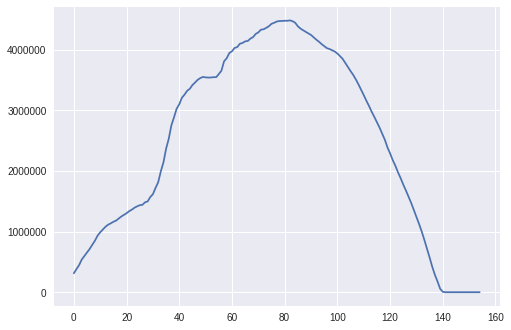

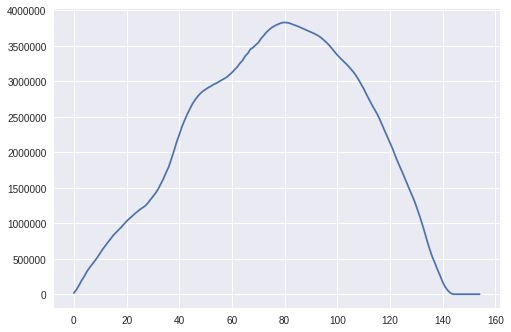

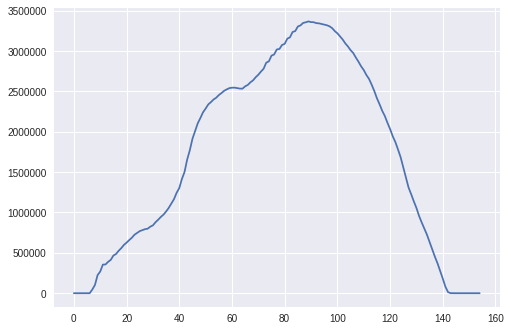

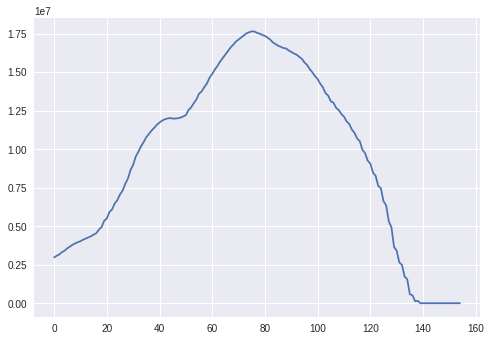

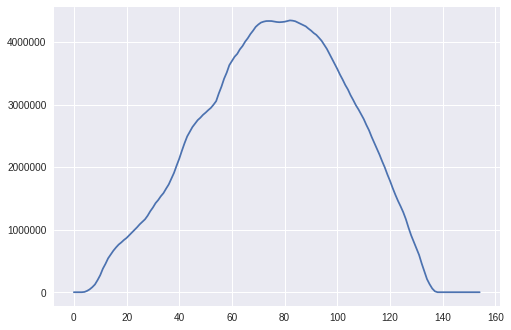

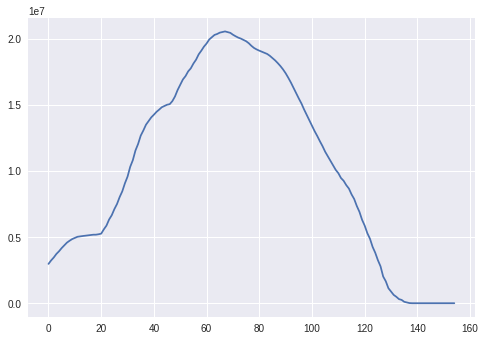

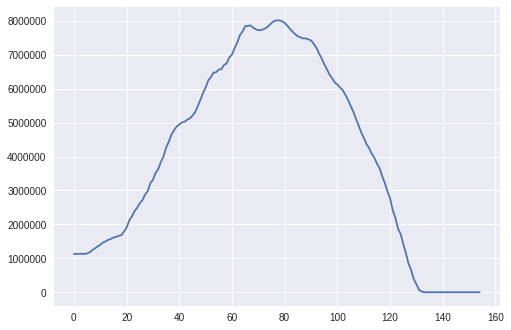

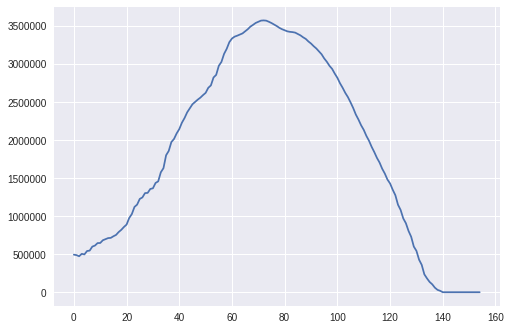

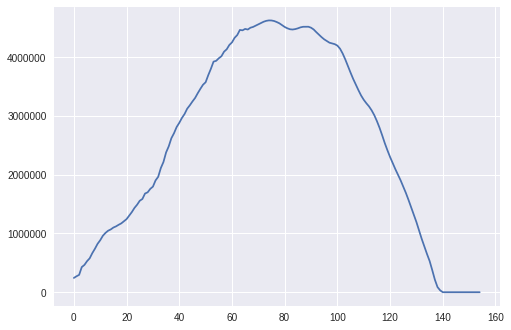

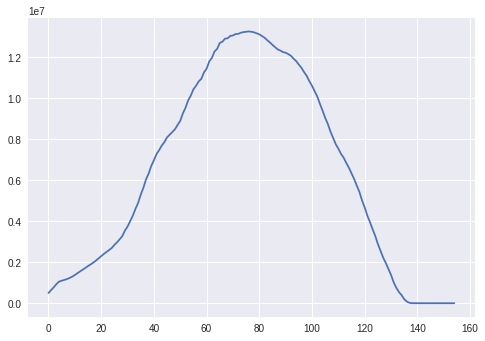

In [0]:
for i in range(10):
  a = next(os.walk(partition['train'][i]))[1]
  a.sort()
  img1= partition['train'][i] + '/'+a[1]+'/'+a[1]+'.mha'
  img=numpy_3D_matrix(img1)
  np.shape(img)
  plt.figure()
  plt.plot(range(155),np.sum(img,axis=(1,2)))
plt.show()


In [0]:
j=0
with h5py.File('./X.h5','w') as hdf:
  with h5py.File('./y.h5','w') as hdf2:
    dset = hdf.create_dataset("X", (2*64*len(completelist), 240,240,1))
    dset2 = hdf2.create_dataset("y", (2*64*len(completelist), 240,240,3))
    for ID in completelist:
    
        a = next(os.walk(ID))[1]
        a.sort()
        img1= sitk.GetArrayFromImage(sitk.ReadImage(ID + '/'+a[1]+'/'+a[1]+'.mha'))
        net_intensity=np.sum(img1,axis=(1,2))
        ind = np.argpartition(net_intensity, -1*64)[-1*64:]
        np.random.shuffle(ind)
        dset[j*64:(j+1)*64] =np.expand_dims(img1[ind,:,:], axis=3)
        img2= sitk.GetArrayFromImage(sitk.ReadImage(ID + '/'+a[4]+'/'+a[4]+'.mha'))
        img=img2[ind,:,:]
        seg_mask_1 = np.zeros((64,240,240))
        seg_mask_1[img == 1] = 1
        seg_mask_1=np.expand_dims(seg_mask_1, axis=3)
        seg_mask_2 = np.zeros((64,240,240))
        seg_mask_2[img == 2] = 1
        seg_mask_2=np.expand_dims(seg_mask_2, axis=3)
        seg_mask_3 = np.zeros((64,240,240))
        seg_mask_3[img == 4] = 1
        seg_mask_3=np.expand_dims(seg_mask_3, axis=3)
        dset2[j*64:(j+1)*64] = np.concatenate([seg_mask_1,seg_mask_2,seg_mask_3], axis=3).astype(int)
        j=j+1
        print(j)
        
    for ID in completelist:
    
        a = next(os.walk(ID))[1]
        a.sort()
        img1= sitk.GetArrayFromImage(sitk.ReadImage(ID + '/'+a[1]+'/'+a[1]+'.mha'))
        net_intensity=np.sum(img1,axis=(1,2))
        ind = np.argpartition(net_intensity, -1*64)[-1*64:]
        np.random.shuffle(ind)
        b=-1*img1[ind,:,:]
        dset[j*64:(j+1)*64] =np.expand_dims(b, axis=3)
        img2= sitk.GetArrayFromImage(sitk.ReadImage(ID + '/'+a[4]+'/'+a[4]+'.mha'))
        img=img2[ind,:,:]
        seg_mask_1 = np.zeros((64,240,240))
        seg_mask_1[img == 1] = 1
        seg_mask_1=np.expand_dims(seg_mask_1, axis=3)
        seg_mask_2 = np.zeros((64,240,240))
        seg_mask_2[img == 2] = 1
        seg_mask_2=np.expand_dims(seg_mask_2, axis=3)
        seg_mask_3 = np.zeros((64,240,240))
        seg_mask_3[img == 4] = 1
        seg_mask_3=np.expand_dims(seg_mask_3, axis=3)
        dset2[j*64:(j+1)*64] = np.concatenate([seg_mask_1,seg_mask_2,seg_mask_3], axis=3).astype(int)
        j=j+1
        print(j)
        



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


<h2>Efficient batch generation  with choosing images with full brain only</h2>Reference: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [0]:
# To suffle

xxx=list(range(2*4375*4))
random.shuffle(xxx)
print(len(completelist))

274


In [0]:
class DataGenerator(tensorflow.keras.utils.Sequence):

    def __init__(self, batch_size=2,train=1):

        self.batch_size = batch_size
        self.suffle_list=xxx
        self.train=train
        self.on_epoch_end()

    def __len__(self):
        #'Denotes the number of batches per epoch'
        if self.train:
          return int(7000)
        else:
          return int(875)
        
    def __getitem__(self, index):
        #'Generate one batch of data'
      aaa=self.suffle_list[index*self.batch_size:(index+1)*self.batch_size]
      aaa.sort()
      if self.train:
        with h5py.File('./X.h5','r') as hdf:
          with h5py.File('./y.h5','r') as hdf2:
#             if index==0 :
            
#               X1=hdf["X"][:3500,:,:,:]
          
#               y1=hdf2["y"][:3500,:,:,:]
#             if index==875:
        
#               X1=hdf["X"][3500:7000,:,:,:]
        
#               y1=hdf2["y"][3500:7000,:,:,:]
#             if index==1750:
         
#               X1=hdf["X"][7000:10500,:,:,:]
          
#               y1=hdf2["y"][7000:10500,:,:,:]
#             if index ==2625:
          
#               X1=hdf["X"][10500:14000,:,:,:]
        
#               y1=hdf2["y"][10500:14000,:,:,:]
          
          
            X=hdf['X'][aaa,:,:,:]
            y=hdf2['y'][aaa,:,:,:]
        return X,y
      else:
        with h5py.File('./X.h5','r') as hdf:
          with h5py.File('./y.h5','r') as hdf2:            
            X=hdf['X'][aaa,:,:,:]
            y=hdf2['y'][aaa,:,:,:]
        return X,y

In [0]:

with h5py.File('./X.h5','r') as hdf:
  print(hdf['X'][1:5,:,:,:].shape)


(4, 240, 240, 1)


<h2>Visualize Your Batch with given batch number</h2>

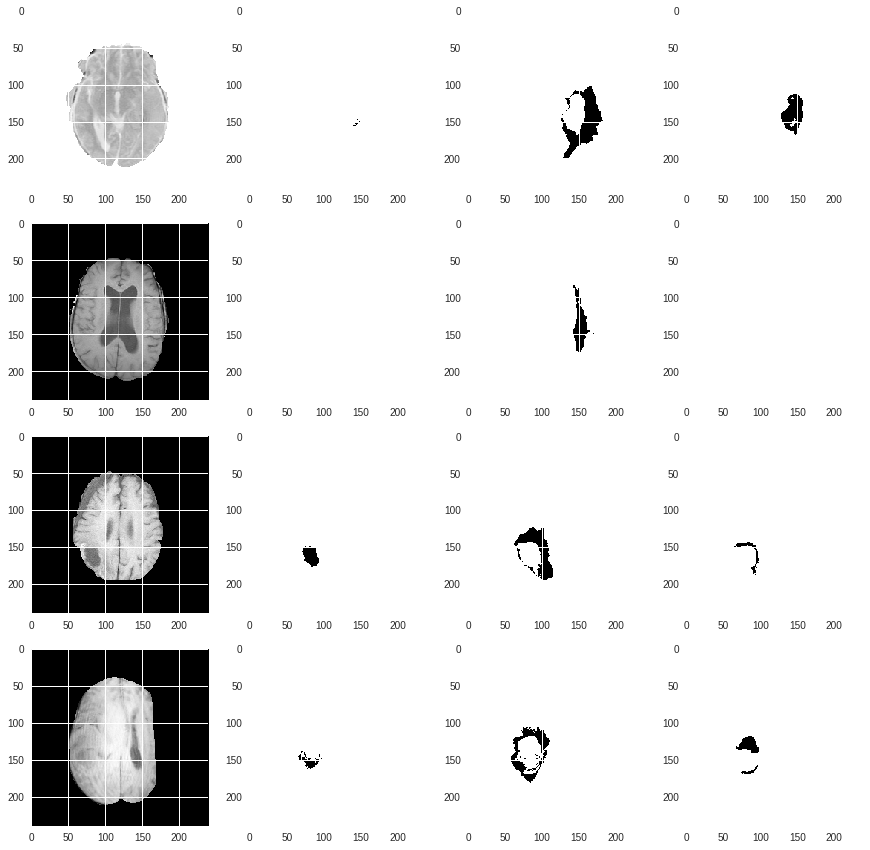

In [0]:
## example

batch_number=101

gen=DataGenerator(4,0)
x,y=gen.__getitem__(batch_number-1)

fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(4):
    img = x[i,:,:,0]
    fig.add_subplot(rows, columns, i*4+1)
    plt.imshow(img.reshape(240,240))
    img = y[i,:,:,0]
    fig.add_subplot(rows, columns, i*4+2)
    plt.imshow(img.reshape(240,240))
    img = y[i,:,:,1]
    fig.add_subplot(rows, columns, i*4+3)
    plt.imshow(img.reshape(240,240))
    img = y[i,:,:,2]
    fig.add_subplot(rows, columns, i*4+4)
    plt.imshow(img.reshape(240,240))
plt.show()

# plt.figure()
# plt.imshow(y[1,:,:,0])
# plt.figure()
# plt.imshow(y[1,:,:,1])
# plt.figure()
# plt.imshow(y[1,:,:,2])

In [0]:
y.shape

(4, 240, 240, 3)

<h1>MODEL</h1><h2>Pre-processing + ResUNet + more filters + data augmentation + dice-loss + segmented image classification</h2>Refernces: https://arxiv.org/pdf/1802.10508v1.pdf , https://arxiv.org/pdf/1701.03056.pdf


<h2>Pre-processing</h2>
Finer details of  the image are enhanced and noise is remove.<br>
References: https://arxiv.org/ftp/arxiv/papers/1702/1702.04528.pdf ,https://www.researchgate.net/publication/319623148_Identification_of_Brain_Tumor_using_Image_Processing_Techniques , https://www.researchgate.net/publication/316700637_BRAIN_TUMOR_DETECTION_USING_IMAGE_PROCESSING_A_SURVEY

<h2>Loss</h2>
Reference: https://arxiv.org/pdf/1707.03237.pdf

In [0]:
def weighted_dice_coefficient(y_true, y_pred, axis=(-3, -2, -1), smooth=0.00001):
    return K.mean(2. * (K.sum(y_true * y_pred,axis=axis) + smooth/2)/(K.sum(y_true,axis=axis) + K.sum(y_pred, axis=axis) + smooth))


def weighted_dice_coefficient_loss(y_true, y_pred):
    return -weighted_dice_coefficient(y_true, y_pred)
    

<h2>Parts to create model</h2>

In [0]:
def create_convolution_block(input_layer, 
                             n_filters, 
                             batch_normalization=False, 
                             kernel=(3, 3), 
                             activation=None,
                             padding='same',
                             strides=1, 
                             instance_normalization=False):
    
    
    layer = Conv2D(n_filters, kernel, padding=padding, strides=strides)(input_layer)
    
    if batch_normalization:
        layer = BatchNormalization()(layer)
    
    elif instance_normalization:
        layer = InstanceNormalization()(layer)
    
    if activation is None:
        return Activation('relu')(layer)
    
    else:
        return activation()(layer)

In [0]:
def compute_level_output_shape(n_filters, depth, pool_size, image_shape):
    output_image_shape = np.asarray(np.divide(image_shape, np.power(pool_size, depth)), dtype=np.int32).tolist()
    return tuple([None, n_filters] + output_image_shape)

In [0]:
def get_up_convolution(n_filters, pool_size, kernel_size=( 2, 2), strides=2,
                       deconvolution=False):
    if deconvolution:
        return Deconvolution2D(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling2D(size=pool_size)

In [0]:
def create_localization_module(input_layer, n_filters):
    convolution1 = create_convolution_block(input_layer, n_filters)
    convolution2 = create_convolution_block(convolution1, n_filters, kernel=(1, 1))
    return convolution2

In [0]:
def create_up_sampling_module(input_layer, n_filters, size=(2, 2)):
    up_sample = UpSampling2D(size=size)(input_layer)
    convolution = create_convolution_block(up_sample, n_filters)
    return convolution

In [0]:
def create_context_module(input_layer, n_level_filters, dropout_rate=0.3, data_format="channels_first"):
    convolution1 = create_convolution_block(input_layer=input_layer, n_filters=n_level_filters)
    dropout = SpatialDropout2D(rate=dropout_rate, data_format=data_format)(convolution1)
    convolution2 = create_convolution_block(input_layer=dropout, n_filters=n_level_filters)
    return convolution2

In [0]:
create_convolution_block = partial(create_convolution_block, activation=LeakyReLU, instance_normalization=True)

<h2>InstanceNormalization</h2>
Reference: https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/layers/normalization/instancenormalization.py

In [0]:
class InstanceNormalization(Layer):
  
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

<h2>Model</h2>

![alt text](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/f5702e1c095b99de32251967dab69ddab341736b/6-Figure4-1.png)

In [0]:
def MODEL(input_shape=(240, 240,1),
                      n_base_filters=16,
                      depth=5, 
                      dropout_rate=0.3,
                      n_segmentation_levels=3,
                      n_labels=4, 
                      optimizer=Adam, 
                      initial_learning_rate=5e-4,
                      loss_function=weighted_dice_coefficient_loss, 
                      activation_name="sigmoid"):    
    
    inputs = Input(input_shape)
    l_inputs = InstanceNormalization()(inputs)
    current_layer=l_inputs

    level_output_layers = list()
    level_filters = list()
    for level_number in range(depth):
        n_level_filters = (2**level_number) * n_base_filters
        level_filters.append(n_level_filters)

        if current_layer is l_inputs:
            in_conv = create_convolution_block(current_layer, n_level_filters)
        else:
            in_conv = create_convolution_block(current_layer, n_level_filters, strides=2)

        context_output_layer = create_context_module(in_conv, n_level_filters, dropout_rate=dropout_rate)

        summation_layer = Add()([in_conv, context_output_layer])
        level_output_layers.append(summation_layer)
        current_layer = summation_layer

    segmentation_layers = list()
    for level_number in range(depth - 2, -1, -1):
        up_sampling = create_up_sampling_module(current_layer, level_filters[level_number])
        concatenation_layer = concatenate([level_output_layers[level_number], up_sampling], axis=3)
        localization_output = create_localization_module(concatenation_layer, level_filters[level_number])
        current_layer = localization_output
        if level_number < n_segmentation_levels:
            segmentation_layers.insert(0, create_convolution_block(current_layer, n_filters=n_labels, kernel=(1, 1)))

    output_layer = None
    for level_number in reversed(range(n_segmentation_levels)):
        segmentation_layer = segmentation_layers[level_number]
        if output_layer is None:
            output_layer = segmentation_layer
        else:
            output_layer = Add()([output_layer, segmentation_layer])

        if level_number > 0:
            output_layer = UpSampling2D(size=(2, 2))(output_layer)

    activation_block = Activation(activation_name)(output_layer)

    model = Model(inputs=inputs, outputs=activation_block)
    #model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=optimizer(lr=initial_learning_rate), loss=loss_function)
    return model

In [0]:
model = MODEL(input_shape=(240, 240,1), n_base_filters=5, depth=4, dropout_rate=0.42856,
                      n_segmentation_levels=3, n_labels=3, optimizer=Adam, initial_learning_rate=0.0010188656670106983,
                      loss_function=weighted_dice_coefficient_loss, activation_name="sigmoid")
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 240, 240, 1)  2           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 5)  50          instance_normalization[0][0]     
__________________________________________________________________________________________________
instance_normalizatio

In [0]:
def log_dir_name(initial_learning_rate=0.001,depth=4,n_base_filters=5,dropout_rate=0.4,optimizer='Adam',loss_function='dice'):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_d_{1}_f_{2}_{3}_o_{4}_l_{5}/"

    log_dir = s.format(initial_learning_rate,
                       depth,
                       n_base_filters,
                       dropout_rate,
                       optimizer,
                       loss_function)

    return log_dir


<h2>Training MODEL</h2>

In [0]:
batch_size=4

training_generator = DataGenerator(batch_size,1)
validation_generator = DataGenerator(batch_size,0)                                                                                                            

cb_1=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
cb_2=tensorflow.keras.callbacks.ModelCheckpoint(filepath='./drive/weights2.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

log_dir = log_dir_name()

cb_3 = tensorflow.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)



results = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                   epochs=10,
                   callbacks=[cb_1,cb_2,cb_3])

Epoch 1/10
7000/7000 [==============================] - 959s 137ms/step - loss: -0.2283 - val_loss: -0.2456
Epoch 2/10
7000/7000 [==============================] - 925s 132ms/step - loss: -0.2451 - val_loss: -0.3167
Epoch 3/10
7000/7000 [==============================] - 918s 131ms/step - loss: -0.3144 - val_loss: -0.3521
Epoch 4/10
7000/7000 [==============================] - 917s 131ms/step - loss: -0.3340 - val_loss: -0.3640
Epoch 5/10
7000/7000 [==============================] - 916s 131ms/step - loss: -0.3423 - val_loss: -0.3687
Epoch 6/10
7000/7000 [==============================] - 914s 131ms/step - loss: -0.3481 - val_loss: -0.3755
Epoch 7/10
7000/7000 [==============================] - 916s 131ms/step - loss: -0.3527 - val_loss: -0.3745
Epoch 8/10
7000/7000 [==============================] - 917s 131ms/step - loss: -0.3563 - val_loss: -0.3890
Epoch 9/10
7000/7000 [==============================] - 916s 131ms/step - loss: -0.3600 - val_loss: -0.3911
Epoch 10/10
7000/7000 [=====

In [0]:
results = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                   epochs=4,
                   callbacks=[cb_1,cb_2,cb_3])

Epoch 1/4
7000/7000 [==============================] - 927s 132ms/step - loss: -0.3658 - val_loss: -0.3924
Epoch 2/4
7000/7000 [==============================] - 928s 133ms/step - loss: -0.3684 - val_loss: -0.3965
Epoch 3/4
7000/7000 [==============================] - 925s 132ms/step - loss: -0.3709 - val_loss: -0.4005
Epoch 4/4
7000/7000 [==============================] - 925s 132ms/step - loss: -0.3731 - val_loss: -0.4050


<h2>Testing MODEL</h2>

In [0]:
#model.load_weights("./weights.01--0.09.hdf5")
validation_generator = DataGenerator(4,0)
prediction = model.predict_generator(generator=validation_generator)

<h2> Testing Method 2</h2>

In [0]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)


# download = drive.CreateFile({'id': '1HVrmqc-wZna6SqvHXspKV3RR7Rl9XlDc'})
# download.GetContentFile('weights1.29--0.46.hdf5')

# model.load_weights("./weights1.29--0.46.hdf5")

batch_number=11

gen=DataGenerator(4,0)
x,y=gen.__getitem__(batch_number-1)
x=x

prediction = model.predict(x)

<h2>Visualize the result</h2>

<Figure size 576x396 with 0 Axes>

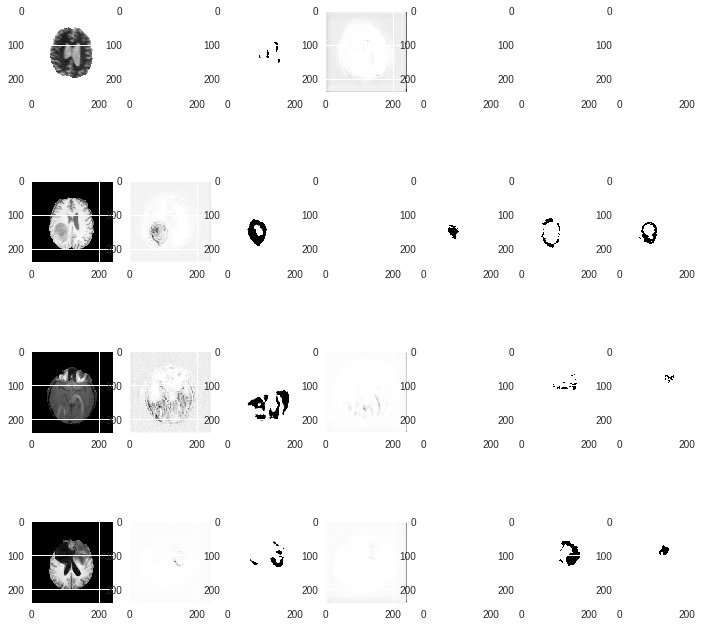

In [0]:

plt.figure()
fig=plt.figure(figsize=(12,12))
columns = 7
rows = 4
for i in range(1, rows+1):
    img = x[i-1,:,:,0]
    fig.add_subplot(rows, columns, 7*i-6)
    plt.imshow(img)
    img = prediction[i-1,:,:,0]
    fig.add_subplot(rows, columns, 7*i-5)
    plt.imshow(img)
    img = prediction[i-1,:,:,1]
    fig.add_subplot(rows, columns, 7*i-4)
    plt.imshow(img)
    img = prediction[i-1,:,:,2]
    fig.add_subplot(rows, columns, 7*i-3)
    plt.imshow(img)
    img = y[i-1,:,:,0]
    fig.add_subplot(rows, columns, 7*i-2)
    plt.imshow(img)
    img = y[i-1,:,:,1]
    fig.add_subplot(rows, columns, 7*i-1)
    plt.imshow(img)
    img = y[i-1,:,:,2]
    fig.add_subplot(rows, columns, 7*i)
    plt.imshow(img)
plt.show()

<h2>Testing on unseen data</h2>

In [0]:
## connect to drive and Locally download the weights

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': '1Z0YDIWXq8tiMKiXR2yvq3w6dXQ3We8L5'})
download.GetContentFile('weights2.10--0.39.hdf5')

model.load_weights("./weights2.10--0.39.hdf5")

# # dowload the data
# download = drive.CreateFile({'id': '14KiK91CV2-8TadCQMT3Bx9U--38qG_xz'})
# download.GetContentFile('normalsVsAbnormalsV1.tar.gz')

# #unzip it
# !tar xvzf normalsVsAbnormalsV1.tar.gz -C ./ 


In [0]:
import cv2
pix = cv2.imread("./abnormalsJPG/IMG-0011-00001.jpg")

plt.imshow(pix[:,:,0])

In [0]:
from skimage.exposure import cumulative_distribution
import matplotlib.pylab as plt
import numpy as np

def cdf(im):
 '''
 computes the CDF of an image im as 2D numpy ndarray
 '''
 c, b = cumulative_distribution(im) 
 # pad the beginning and ending pixels and their CDF values
 c = np.insert(c, 0, [0]*b[0])
 c = np.append(c, [1]*(255-b[-1]))
 return c

def hist_matching(c, c_t, im):
 '''
 c: CDF of input image computed with the function cdf()
 c_t: CDF of template image computed with the function cdf()
 im: input image as 2D numpy ndarray
 returns the modified pixel values
 ''' 
 pixels = np.arange(256)
 # find closest pixel-matches corresponding to the CDF of the input image, given the value of the CDF H of   
 # the template image at the corresponding pixels, s.t. c_t = H(pixels) <=> pixels = H-1(c_t)
 new_pixels = np.interp(c, c_t, pixels) 
 im = (np.reshape(new_pixels[im.ravel()], im.shape)).astype(np.uint8)
 return im

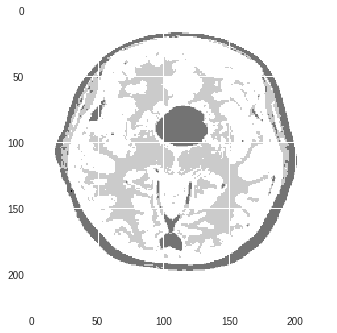

In [0]:
with h5py.File('./X.h5','r') as hdf:
  img=hdf['X'][51,:,:,0]
img = img - np.mean(img)
img = img / np.std(img)
plt.imshow(img)
plt.imshow(hist_matching(cdf(pix[:,:,0]),cdf(80*img.astype(int)),pix[:,:,0]))

In [0]:
from skimage.transform import resize
pix = resize(pix,(240,240))
pix=np.expand_dims(pix, axis=0)
print(pix.shape)
print(np.shape(np.expand_dims(pix[:,:,:,0],axis=3)))

(1, 240, 240, 3)
(1, 240, 240, 1)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<Figure size 576x396 with 0 Axes>

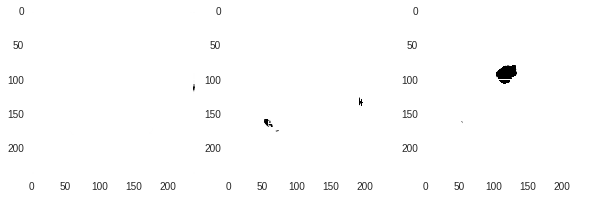

In [0]:
y=model.predict(np.expand_dims(pix[:,:,:,0],axis=3))
columns = 3
rows = 1
plt.figure()
fig=plt.figure(figsize=(10,30))
img = y[0,:,:,0]
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
img = y[0,:,:,1]
fig.add_subplot(rows, columns, 2)
plt.imshow(img)
img = y[0,:,:,2]
fig.add_subplot(rows, columns, 3)
plt.imshow(img)

<h2>Restart Training</h2> 

In [0]:
# download = drive.CreateFile({'id': '1BmsQ-CAkH9wcmUYouWke_4_Hxzw2Tl3E'})
# download.GetContentFile('weights1.02--0.28.hdf5')

batch_size=4

training_generator = DataGenerator(batch_size,1)
validation_generator = DataGenerator(batch_size,0) 
cb_1=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
cb_2=tensorflow.keras.callbacks.ModelCheckpoint(filepath='./drive/weights1.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

log_dir = log_dir_name()

cb_3 = tensorflow.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)                                                                                                            

model.load_weights("./weights1.10--0.37.hdf5")

results = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                   epochs=30,
                   callbacks=[cb_1,cb_2,cb_3])

Epoch 1/30
3500/3500 [==============================] - 524s 150ms/step - loss: -0.3565 - val_loss: -0.3718
Epoch 2/30
3500/3500 [==============================] - 528s 151ms/step - loss: -0.3621 - val_loss: -0.3802
Epoch 3/30
3500/3500 [==============================] - 530s 151ms/step - loss: -0.3670 - val_loss: -0.3942
Epoch 4/30
3500/3500 [==============================] - 524s 150ms/step - loss: -0.3714 - val_loss: -0.3940
Epoch 5/30
3500/3500 [==============================] - 529s 151ms/step - loss: -0.3744 - val_loss: -0.3985
Epoch 6/30
3500/3500 [==============================] - 528s 151ms/step - loss: -0.3787 - val_loss: -0.4021
Epoch 7/30
3500/3500 [==============================] - 526s 150ms/step - loss: -0.3819 - val_loss: -0.4028
Epoch 8/30
3500/3500 [==============================] - 529s 151ms/step - loss: -0.3854 - val_loss: -0.4102
Epoch 9/30
3500/3500 [==============================] - 525s 150ms/step - loss: -0.3883 - val_loss: -0.4090
Epoch 10/30
3500/3500 [=====

In [0]:
print(results.history.keys())

dict_keys(['val_loss', 'loss'])


<h2>Training & validation loss</h2>

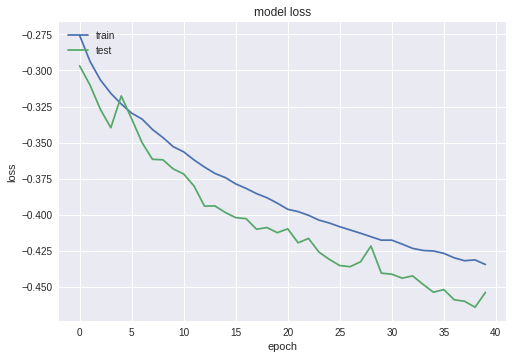

In [0]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# download = drive.CreateFile({'id': '1_twF2WIlqlbTyEci2vcslBX5BTBsglsX'})
# download.GetContentFile('loss.npy')

# download = drive.CreateFile({'id': '1WuZQvA6uagI-MuW9U4JA1Ep3La5NgkfI'})
# download.GetContentFile('val_loss.npy')

# loss=np.load('loss.npy')
# val_loss=np.load('val_loss.npy')

## summarize history for loss

np.save('./drive/loss5.npy',results.history['loss'])
np.save('./drive/val_loss5.npy',results.history['val_loss'])

plt.plot(np.append(np.load('loss.npy'),results.history['loss']))
plt.plot(np.append(np.load('val_loss.npy'),results.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
np.save('loss.npy',results.history['loss'])

In [0]:
np.save('val_loss.npy',results.history['val_loss'])

<h2>Save loss values</h2>

In [0]:
np.save('loss1.npy',np.append(loss,results.history['loss']))
np.save('val_loss1.npy',np.append(val_loss,results.history['val_loss']))
loss=np.load('loss.npy')
val_loss=np.load('val_loss.npy')

<h1> HyperParameter Tuning</h1>Reference: http://www.gaussianprocess.org/gpml/chapters/RW5.pdf, https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/19_Hyper-Parameters.ipynb<h2>Ranges to search for HyperParameters</h2>

In [0]:
dim_initial_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='initial_learning_rate')

dim_depth = Integer(low=2, high=5, name='depth')

dim_n_base_filters = Integer(low=2, high=32, name='n_base_filters')

dim_dropout_rate = Real(low=0, high=1 , name='dropout_rate')

dim_optimizer = Categorical(categories=[Adam, SGD], name='optimizer')

dim_loss_function=Categorical(categories=[weighted_dice_coefficient_loss,'binary_crossentropy','mean_squared_error'], name= 'loss_function')

dimensions = [dim_initial_learning_rate,
              dim_depth,
              dim_n_base_filters,
              dim_dropout_rate,
             dim_optimizer,
             dim_loss_function]

default_parameters = [5e-4, 5, 16, 0.3, Adam,weighted_dice_coefficient_loss]

<h2>Helper-function for log-dir-name</h2>

In [0]:
def log_dir_name(initial_learning_rate=0.001,depth=4,n_base_filters=5,dropout_rate=0.4,optimizer='Adam',loss_function='dice'):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_d_{1}_f_{2}_{3}_o_{4}_l_{5}/"

    log_dir = s.format(initial_learning_rate,
                       depth,
                       n_base_filters,
                       dropout_rate,
                       optimizer,
                       loss_function)

    return log_dir


In [0]:
path_best_model = '19_best_model.keras'

In [0]:
best_score = 0.0

n=0

<h2>Fitness functon</h2>

In [0]:
@use_named_args(dimensions=dimensions)
def fitness(initial_learning_rate,depth,n_base_filters,dropout_rate,optimizer,loss_function):
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(initial_learning_rate))
    print('depth:', depth)
    print('n_base_filters:', n_base_filters)
    print('dropout_rate:', dropout_rate)
    print('optimizer:',optimizer)
    print()
    
    global n
    n=n+1
    # Create the neural network with these hyper-parameters.
    model = MODEL(input_shape=(240, 240,1), n_base_filters=n_base_filters, depth=depth, dropout_rate=dropout_rate,
                      n_segmentation_levels=depth-1, n_labels=3, optimizer=optimizer, initial_learning_rate=initial_learning_rate,
                      loss_function=loss_function, activation_name="sigmoid")
    
    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(initial_learning_rate,depth,n_base_filters,dropout_rate,optimizer,loss_function)
    
    # Create a callback-function for Keras which will be
    cb_3 = tensorflow.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
    

    training_generator = DataGenerator(4,1)
    validation_generator = DataGenerator(4,0)
    
    cb_1=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto')
    cb_2=tensorflow.keras.callbacks.ModelCheckpoint(filepath='./'+str(n)+'.weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    
    results = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                   epochs=1,
                   callbacks=[cb_1,cb_2,cb_3])
    
    score=-1*results.history['val_loss'][-1]
    
    print()
    print("Score:{0:.2}".format(score))
    
    global best_score
    
    if score > best_score:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_score = score

    
    del model
    
    K.clear_session()
    
    return -1*score
    

<h2> Parameters Search</h2>

In [0]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=11,
                            x0=default_parameters)

learning rate: 5.0e-04
depth: 5
n_base_filters: 16
dropout_rate: 0.3
optimizer: <class 'tensorflow.python.keras.optimizers.Adam'>

Instructions for updating:
Use tf.cast instead.
3500/3500 [==============================] - 1185s 339ms/step - loss: -0.0608 - val_loss: -0.1172

Score:0.12
learning rate: 9.1e-04
depth: 3
n_base_filters: 21
dropout_rate: 0.46356371816288877
optimizer: <class 'tensorflow.python.keras.optimizers.Adam'>

3500/3500 [==============================] - 1091s 312ms/step - loss: -0.0513 - val_loss: -0.0937

Score:0.094
learning rate: 8.8e-04
depth: 5
n_base_filters: 11
dropout_rate: 0.19630819094036417
optimizer: <class 'tensorflow.python.keras.optimizers.SGD'>

Instructions for updating:
Use tf.cast instead.
3500/3500 [==============================] - 911s 260ms/step - loss: 0.2430 - val_loss: 0.2099

Score:-0.21
learning rate: 1.3e-06
depth: 4
n_base_filters: 28
dropout_rate: 0.32164523540244466
optimizer: <class 'tensorflow.python.keras.optimizers.Adam'>

3500

<h1>Visualizations</h1><h2>Optimization Progress</h2>

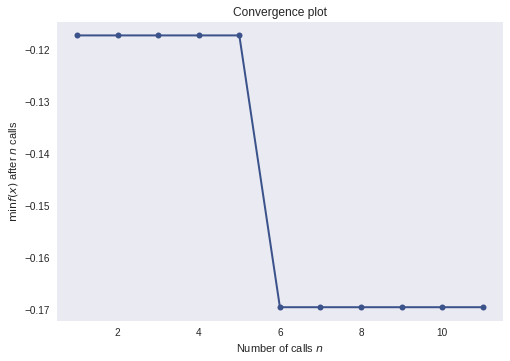

In [0]:
plot_convergence(search_result)

<h2>Best Hyper-Parameters</h2>

In [0]:
skopt.space.point_to_dict(search_result.x)

In [0]:
search_result.fun

-0.16962478385864133

In [0]:
sorted(zip(search_result.func_vals,search_result.x_iters))

[(-0.16962478385864133,
  [0.0010188656670106983,
   4,
   5,
   0.42856069481267756,
   tensorflow.python.keras.optimizers.Adam,
   <function __main__.weighted_dice_coefficient_loss>]),
 (-0.11724570664532227,
  [0.0005,
   5,
   16,
   0.3,
   tensorflow.python.keras.optimizers.Adam,
   <function __main__.weighted_dice_coefficient_loss>]),
 (-0.09370783264034883,
  [0.0009064627316644866,
   3,
   21,
   0.46356371816288877,
   tensorflow.python.keras.optimizers.Adam,
   <function __main__.weighted_dice_coefficient_loss>]),
 (-0.02746950011292852,
  [1.3023176111459398e-06,
   4,
   28,
   0.32164523540244466,
   tensorflow.python.keras.optimizers.Adam,
   <function __main__.weighted_dice_coefficient_loss>]),
 (-0.01162028915899106,
  [8.457004922769993e-06,
   3,
   7,
   0.21432664078191893,
   tensorflow.python.keras.optimizers.SGD,
   <function __main__.weighted_dice_coefficient_loss>]),
 (-0.011428970503404112,
  [7.78982534230823e-06,
   4,
   10,
   0.8210383968947188,
   tens

<h2>Most  used Optimizer

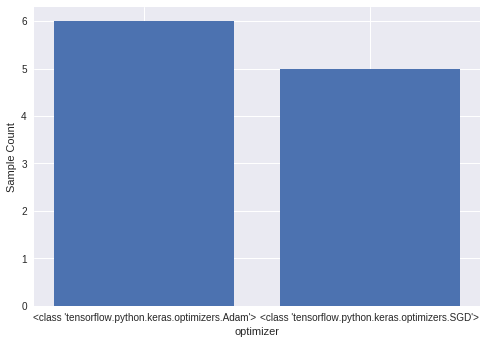

In [0]:
fig, ax = plot_histogram(result=search_result, dimension_name='optimizer')

<h2>Most used Loss</h2>

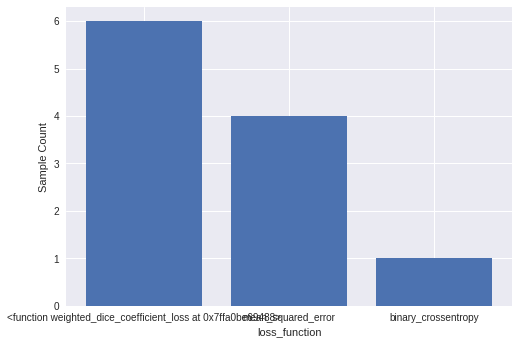

In [0]:
fig, ax = plot_histogram(result=search_result, dimension_name='loss_function')

<h2>Partial Dependency Plots</h2>

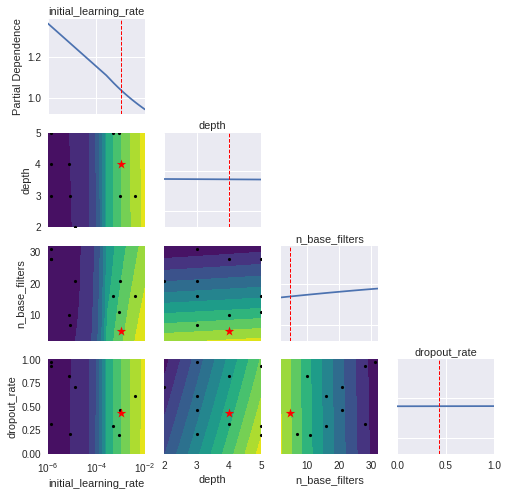

In [0]:
dim_names= ['initial_learning_rate','depth','n_base_filters','dropout_rate']

fig,ax = plot_objective(result=search_result, dimension_names=dim_names)

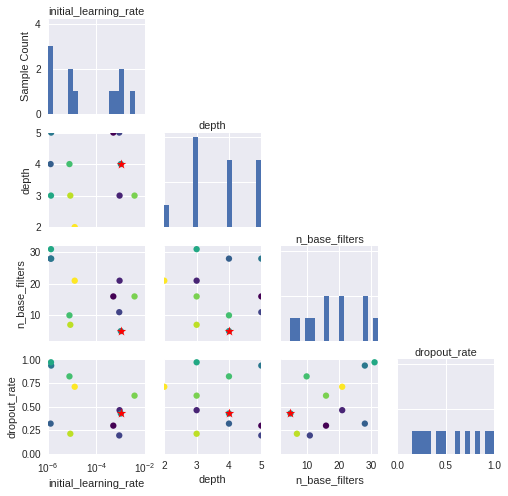

In [0]:
fig, ax = plot_evaluations(result=search_result, dimension_names=dim_names)

<h1>Run the best Model</h1>

In [0]:
model=load_model(path_best_model)

validation_generator = DataGenerator(partition['test'], **params)
prediction = model.predict_generator(generator=validation_generator)

In [0]:
print(search_result)

          fun: -0.16962478385864133
    func_vals: array([-0.11724571, -0.09370783,  0.20992987, -0.0274695 ,  0.99260506,
       -0.16962478,  0.99260506, -0.01142897,  0.1384628 , -0.01162029,
        2.94951931])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=2, noise='gaussian', normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=1215645328)]
 random_state: <mtrand.RandomState object at 0x7ffa7c40c708>
        space: Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize', name='initial_learning_rate'),
       Integer(low=2, high=5, name='depth'),
       Integer(low=2, high=32, name='n_base_filters'),
       Real(low=0, high=1, prior='uniform', transform='normalize', name='dropout_rate'),
       Categorical(categories=(<class 'tensorflow.python.keras.optimizers.Adam'>, <clas

In [0]:
del model
K.clear_session()

In [0]:
print()

In [0]:
print()

In [0]:
print(0)

0
